In [2]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inline

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING LAB DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate chart data for the first 24hrs of a patients icu stay as well as demographic data for patients diagnosed with sepsis according to the Angus criteria. 
(Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file LAB_EVENTS_ANGUS_FIRST24.csv. The data was read into a pandas dataframe lab_events. 


In [3]:
data = pd.DataFrame.from_csv('LAB_EVENTS_FIRST24.csv')
data.loc[:,'charttime']  = pd.to_datetime(data.loc[:,'charttime'])
data = data.sort_values(['icustay_id', 'charttime'],ascending=True)
data.head()

,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
subject_id,,,,,,,
55973,200001,F,Hematocrit,2181-11-25 16:16:00,26.10,abnormal,0
55973,200001,F,White Blood Cells,2181-11-25 16:16:00,2.90,abnormal,0
55973,200001,F,pH,2181-11-25 17:00:00,5.00,NaN,0
55973,200001,F,Lactate,2181-11-25 19:27:00,1.40,NaN,0
55973,200001,F,pH,2181-11-25 19:27:00,7.41,NaN,0


## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [4]:
print "loading lab data"
data['subject_id'] = data.index
data.set_index(np.arange(data.shape[0]), inplace = True)
cols = list(data.columns)
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
data = data[cols]
print "complete"

loading lab data
complete


In [5]:
data2 = data.drop_duplicates('icustay_id', keep = 'first')
data3 = data.drop_duplicates('subject_id', keep = 'first')

print "The number of unique ICU stays = {}".format(data2.shape[0])
print "The number of unique patients  = {}".format(data3.shape[0])

# display the different measurements captured in the database query
labels = data.label.unique()
display(data.shape)
display(data[(data.label=='Lactate') & (~(data.valuenum.isnull()))].head())
display(labels)

The number of unique ICU stays = 59798
The number of unique patients  = 45260


(943120, 8)

,icustay_id,subject_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
3,200001,55973,F,Lactate,2181-11-25 19:27:00,1.4,NaN,0
26,200003,27513,M,Lactate,2199-08-03 01:55:00,5.1,abnormal,0
29,200003,27513,M,Lactate,2199-08-03 03:42:00,4.1,abnormal,0
36,200003,27513,M,Lactate,2199-08-03 17:52:00,2.6,abnormal,0
44,200006,10950,M,Lactate,2159-09-03 08:11:00,3.1,abnormal,0


array(['Hematocrit', 'White Blood Cells', 'pH', 'Lactate', 'Creatinine',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Oxygen Saturation',
       'Creatinine, Urine', '24 hr Creatinine', 'Urine Creatinine',
       'WBC Count'], dtype=object)

In [7]:
# REMOVE VARIABLES FOR WHICH THERE IS LITTLE DATA / FEW ICUSTAYS FOR WHICH DATA WAS RECORDED
labels2 = []

for item in labels:
    num_samps = data['icustay_id'][data.label == item].dropna().unique().shape[0]
    #num_measures = data[data.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    print "{}    {}".format(item, num_samps) #, num_measures)
    if num_samps > 6000:
        print "adding {}".format(item)
        labels2.append(item)
labels2.sort(key=str.lower)
labels2

Hematocrit    59404
adding Hematocrit
White Blood Cells    59175
adding White Blood Cells
pH    45343
adding pH
Lactate    31261
adding Lactate
Creatinine    52902
adding Creatinine
Glucose    51725
adding Glucose
Lactate Dehydrogenase (LD)    14542
adding Lactate Dehydrogenase (LD)
Oxygen Saturation    19243
adding Oxygen Saturation
Creatinine, Urine    6719
adding Creatinine, Urine
24 hr Creatinine    21
Urine Creatinine    4
WBC Count    173


['Creatinine',
 'Creatinine, Urine',
 'Glucose',
 'Hematocrit',
 'Lactate',
 'Lactate Dehydrogenase (LD)',
 'Oxygen Saturation',
 'pH',
 'White Blood Cells']

In [8]:
# calculating the number of samples taken in 24 hours for each measurement
item = labels2[0]

num_samps_df =  data[data.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
   
for item in labels2[1:]:
    #num_samps = data['icustay_id'][data.label == item].dropna().unique().shape[0]
    monkey = data[data.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    monkey.columns = [item]
    num_samps_df = num_samps_df.merge(monkey,left_index = True, right_index = True, how = 'left', sort = True) 
    #print "{}    {}".format(item, num_measures) #, num_measures)

#num_samps_df.drop('label', axis=1, inplace = True)
num_samps_df.dropna().head(30)

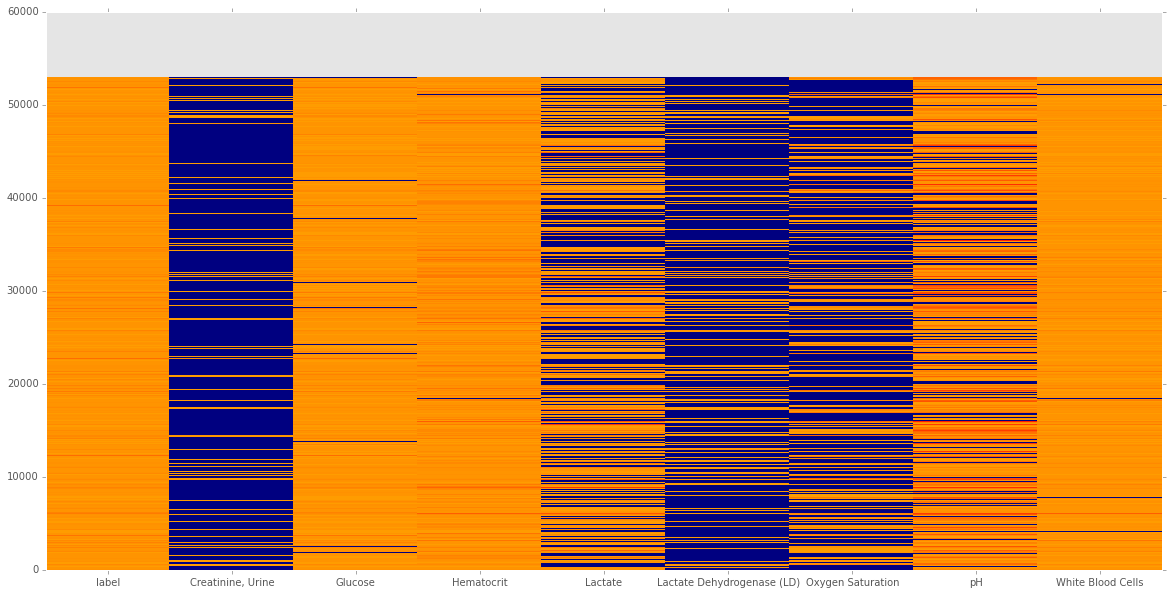

In [11]:
# DISPLAY COLORMAP OF THE NUMBER OF SAMPLES WITH MISSING DATA HIGHLIGHTED
# REFERRING TO THIS AS AN AFFINITY MAP, SHOWING WHICH DATA WAS COLLECTED MOST OFTEN TOGETHER. 
# ASSIGNING NaN A NEGATIVE VALUE MAKES MISSING DATA APPEAR DARK BLUE
header = num_samps_df.replace(np.nan, -100, inplace = False)
plt.figure(figsize= (20,10))
plt.pcolor(header)
#plt.yticks(np.arange(0.5, len(header.index), 1), header.index)
plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
plt.show()


In [51]:
#display(data.dtypes)
monkey = data[data.label == 'pH'].groupby('icustay_id')['flag'].agg(lambda group: 1 if 'abnormal' in group else 0)

monkey.head()

icustay_id
200001    0
200003    0
200006    0
200009    0
200011    0
Name: flag, dtype: int64

In [60]:
monkey = data[(data.label == 'pH')]
display(monkey.head(30))
#display('abnormal' in monkey.flag.values)

,icustay_id,subject_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
2,200001,55973,F,pH,2181-11-25 17:00:00,5.00,NaN,0
4,200001,55973,F,pH,2181-11-25 19:27:00,7.41,NaN,0
10,200001,55973,F,pH,2181-11-26 11:07:00,7.40,NaN,0
12,200001,55973,F,pH,2181-11-26 17:44:00,7.33,abnormal,0
14,200001,55973,F,pH,2181-11-26 18:56:00,7.40,NaN,0
20,200003,27513,M,pH,2199-08-02 22:05:00,5.00,NaN,0
28,200003,27513,M,pH,2199-08-03 01:55:00,7.36,NaN,0
30,200003,27513,M,pH,2199-08-03 03:42:00,7.38,NaN,0
31,200003,27513,M,pH,2199-08-03 10:49:00,7.46,abnormal,0
37,200003,27513,M,pH,2199-08-03 17:52:00,7.38,NaN,0


In [59]:
monkey = data[data.label == 'pH'].groupby('icustay_id')['flag'].apply(lambda x: 1 if 'abnormal' in x.values else 0)
monkey.head()

icustay_id
200001    1
200003    1
200006    0
200009    1
200011    1
Name: flag, dtype: int64

## Calculating values from original data including mean, std, delta etc. 


In [110]:
# height and weight are left out from the calculated measures because there was only one
# measurement so they are constant.



# labels2 were sorted alphabetically so we order this list accordingly before zipping
dict_names = ['Creat','CreatUrine', 'Gluc', 'Hemat', 'Lac', 'LacDehyd', 'O2sat', 'pH', 'WBC']

# CREATE DICTS OF VARIABLE NAMES WITH MEASUREMENT INDICATOR APPENDED AS KEYS AND 
# LABELS AS ENTRIES
first_dict_names = dict(zip([item + '_first' for item in dict_names], labels2))
mean_dict_names = dict(zip([item + '_mean' for item in dict_names], labels2))
med_dict_names = dict(zip([item + '_med' for item in dict_names], labels2))
std_dict_names = dict(zip([item + '_std' for item in dict_names], labels2))
skew_dict_names = dict(zip([item + '_skew' for item in dict_names], labels2))
min_dict_names = dict(zip([item + '_min' for item in dict_names], labels2))
max_dict_names = dict(zip([item + '_max' for item in dict_names], labels2))
slope_dict_names = dict(zip([item + '_slope' for item in dict_names], labels2))
delta_dict_names = dict(zip([item + '_delta' for item in dict_names], labels2))
abnflag_dict_names = dict(zip([item + '_abnflag' for item in dict_names], labels2))

# CREATE LIST OF NAMES_DICTS FOR EASY TRAVERSAL / ITERATION AND FOR ZIPPING INTO DICTIONARY
names_list = [first_dict_names, mean_dict_names, med_dict_names, std_dict_names, skew_dict_names, 
              min_dict_names, max_dict_names, slope_dict_names, delta_dict_names, abnflag_dict_names ]
# CREATE LIST FOR ZIPPING INTO DICTIONARY THE MEASUREMENT TYPE AND THE CORRESPONDING NAMES_DICT
calc_list = ['first', 'mean', 'med', 'std', 'skew', 'min', 'max', 'slope', 'delta', 'abnflag']

# CREATE DICTIONARY WHERE KEY IS THE TYPE OF CALCULATION AND THE VALUE IS THE NAMES_DICT 
names_dict = dict(zip(calc_list, names_list))


# CREATE DICTIONARIES IN WHICH TO STORE CALCULATED VALUES
first_dict = {}
mean_dict = {}
med_dict = {}
std_dict = {}
skew_dict = {}
kurt_dict = {}
min_dict = {}
max_dict = {}
slope_dict = {}
delta_dict = {}
abnflag_dict = {}
dict_list = [first_dict, mean_dict, med_dict, std_dict, skew_dict, min_dict, max_dict, slope_dict, delta_dict,
            abnflag_dict]
calc_dict = dict(zip(calc_list, dict_list))

# ITERATING THROUGH THE VARIABLES, CALCULATING MEANS, MEDIANS, STD, SKEWNESS, MIN AND MAX'S FOR EACH ITERATION
# VARIABLES WITH TOO FEW MEASUREMENTS TO CALCULATE THINGS LIKE STD WILL BE AUTOMATICALLY ASSIGNED 'NaN' VALUE
print "Creating data frames for each summary statistic for each time course variable"
for calc_key in calc_dict.keys():
    for col_key in names_dict[calc_key].keys(): 
        if calc_key == 'mean':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].mean())
        elif calc_key == 'med':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].median())
        elif calc_key == 'std':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].std())
        elif calc_key == 'max':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].max())
        elif calc_key == 'min':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].min())
        elif calc_key == 'first': 
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'skew':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].skew())
        elif calc_key == 'delta': 
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last() -
                                                        data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'abnflag':
            calc_dict[calc_key][col_key] = pd.DataFrame(data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['flag'].apply(lambda x: 1 if 'abnormal' in x.values else 0))
              
        elif calc_key == 'slope':
            time_last = data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].last()
            time_first = data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].first()
            val_last = data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last()
            val_first = data[data.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first()
            calc_dict[calc_key][col_key] = pd.DataFrame((val_last - val_first)/((time_last - time_first)/np.timedelta64(1,'h')))           
        
            
        else: 
            print "need to add code for calculating {}".format(calc_key)
            break
            
        calc_dict[calc_key][col_key].replace([np.inf, -np.inf], np.nan, inplace = True)
        calc_dict[calc_key][col_key].columns = [col_key]
        calc_dict[calc_key][col_key]['hospital_expire_flag'] = data.groupby('icustay_id').hospital_expire_flag.first()
        calc_dict[calc_key][col_key]['gender'] = data.groupby('icustay_id').gender.first()

print "complete"

Creating data frames for each summary statistic for each time course variable
complete


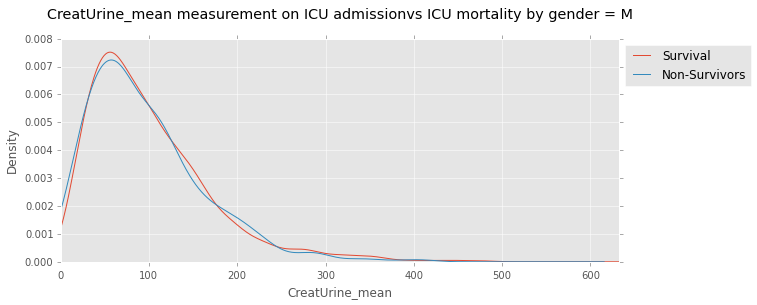

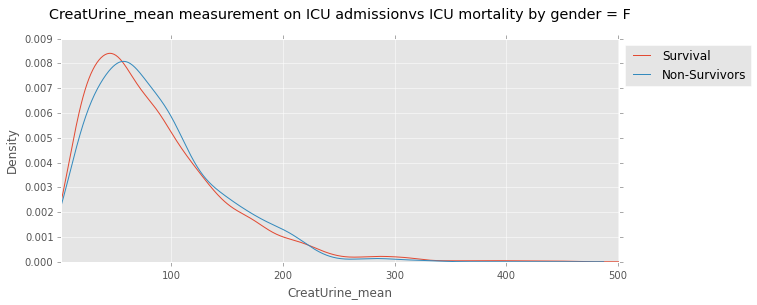

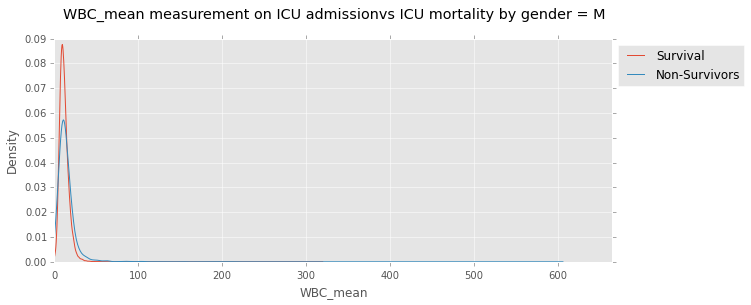

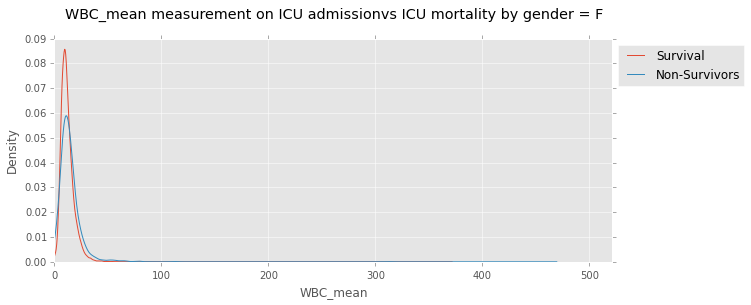

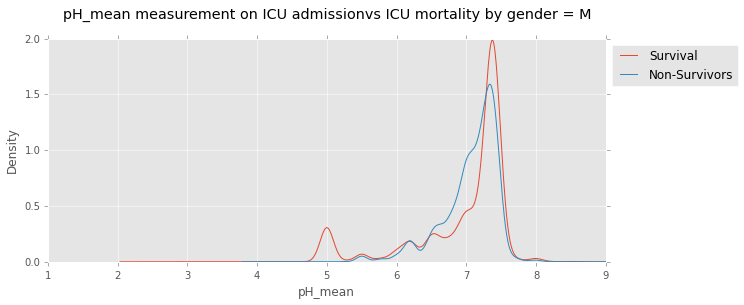

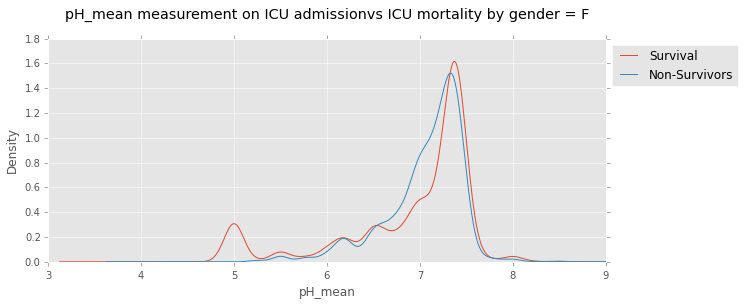

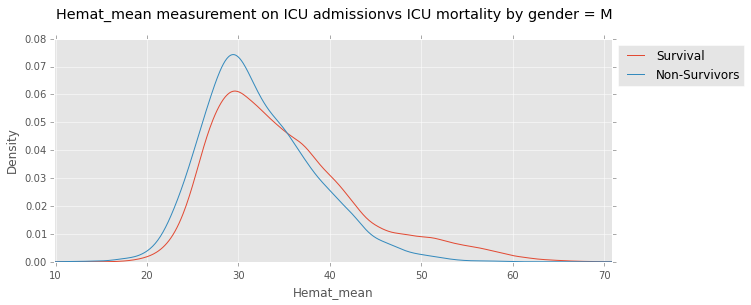

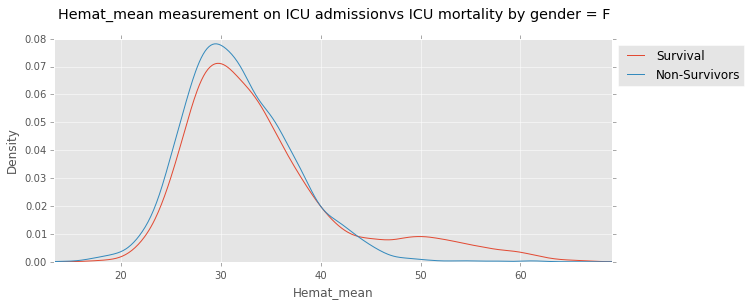

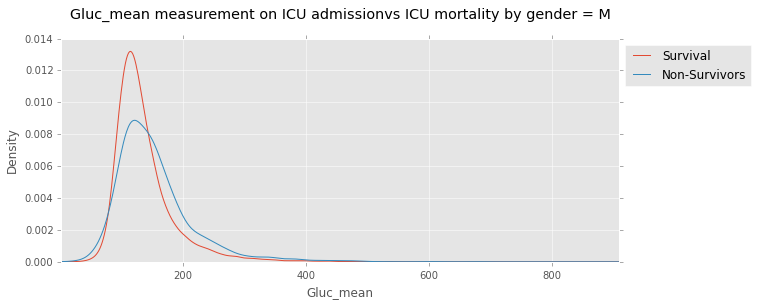

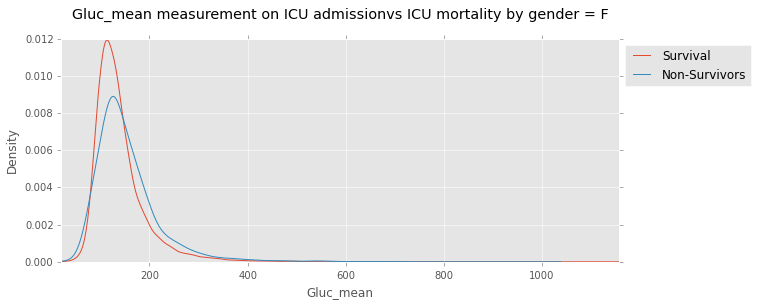

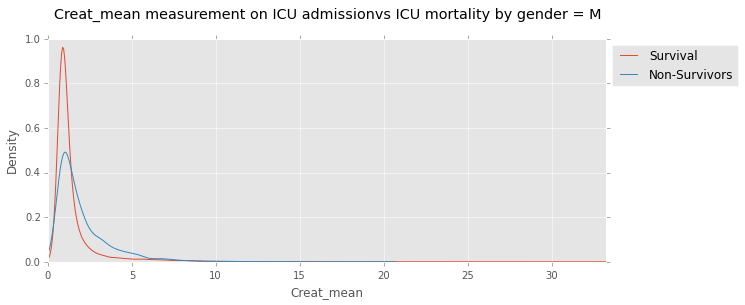

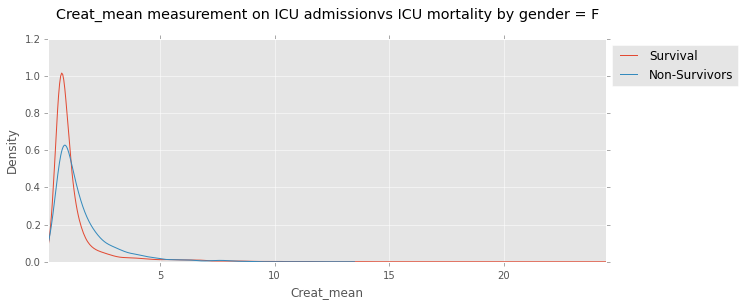

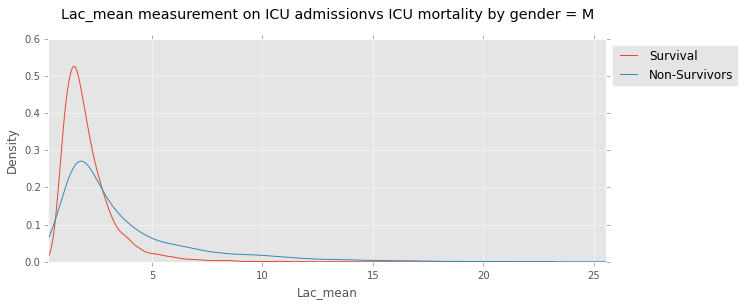

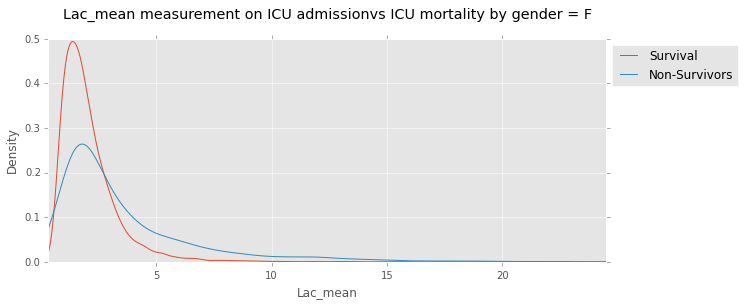

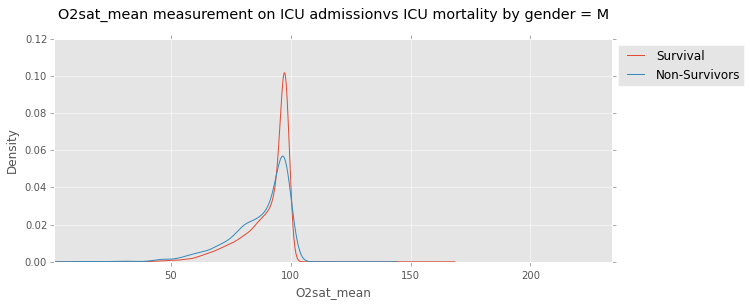

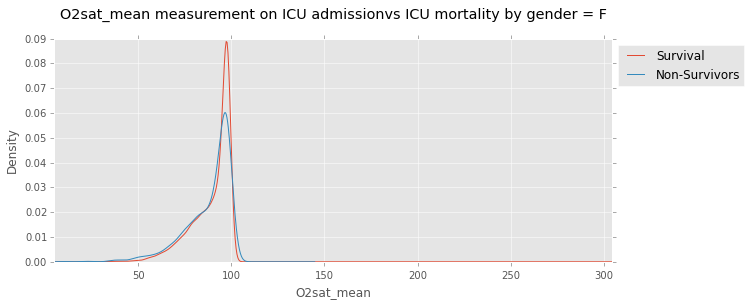

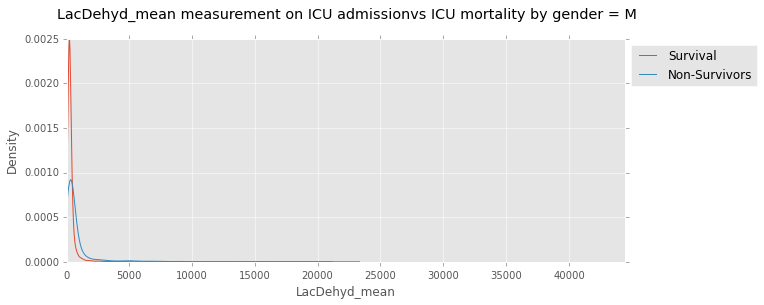

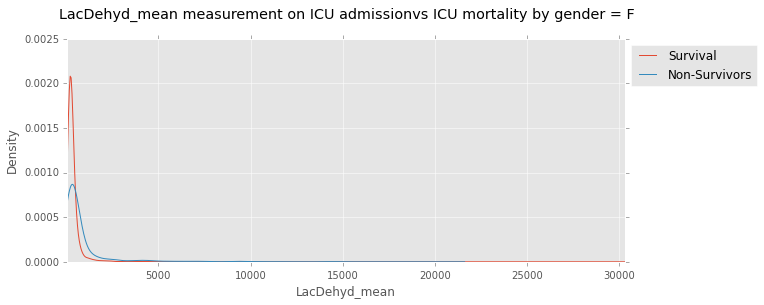

In [117]:
#mean_dict[mean_dict.keys()[0]].head()
dummy = calc_dict['mean']

for col in dummy.keys():
    
    col2 = dummy[col].columns[0]
    
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        #print gend
        dead = dummy[col][(dummy[col].hospital_expire_flag == 1)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].dropna().max()#quantile(0.999)
        live_min = live[col2].dropna().min()#quantile(0.001)
        dead_max = dead[col2].dropna().max()#quantile(0.999)
        dead_min = dead[col2].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        plt.subplots(figsize=(10,4))
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Survival')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        plt.xlim(minlim, maxlim)

In [118]:
# MERGING INDIVIDUAL CALCULATED FRAMES INTO A SINGLE DATAFRAME
data2 = data.drop_duplicates('icustay_id', keep = 'first')
data3 = data2.drop(['label', 'charttime', 'valuenum', 'flag'], axis = 1)
data3.set_index(['icustay_id'], inplace = True)

for calc_key in calc_dict.keys():
    print "merging {} dataframe".format(calc_key)
    for col_key in calc_dict[calc_key].keys(): 
        col2 = calc_dict[calc_key][col_key]
        data3 = data3.merge(pd.DataFrame(calc_dict[calc_key][col_key][col_key]), left_index = True, 
                           right_index = True, how = 'left', sort = True)
        newcols = list(data3.columns)
        newcols.pop()
        newcols.append(col_key)
        data3.columns = newcols
display(data3.shape)
display(data3.head())
        
# OLD CODE


merging std dataframe
merging med dataframe
merging abnflag dataframe
merging slope dataframe
merging min dataframe
merging max dataframe
merging skew dataframe
merging delta dataframe
merging first dataframe
merging mean dataframe


(59798, 93)

,subject_id,gender,hospital_expire_flag,pH_std,Hemat_std,Gluc_std,CreatUrine_std,O2sat_std,WBC_std,LacDehyd_std,...,Creat_first,CreatUrine_mean,WBC_mean,pH_mean,Hemat_mean,Gluc_mean,Creat_mean,Lac_mean,O2sat_mean,LacDehyd_mean
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,55973,F,0,1.067085,1.767767,NaN,NaN,5.656854,0.070711,NaN,...,2.7,NaN,2.850000,6.908000,24.850000,87.000000,2.700000,1.400000,92.0,209.0
200003,27513,M,0,0.979600,2.059935,35.501174,NaN,1.414214,15.841191,17.67767,...,0.9,NaN,32.966667,6.998333,33.433333,119.666667,0.866667,3.933333,97.0,203.5
200006,10950,M,0,NaN,6.269237,109.601551,NaN,NaN,6.091251,NaN,...,1.1,NaN,7.666667,6.000000,28.666667,148.500000,0.950000,3.100000,NaN,NaN
200007,20707,M,0,NaN,4.454773,30.512293,NaN,NaN,2.333452,NaN,...,0.9,NaN,9.550000,NaN,41.250000,242.000000,0.833333,NaN,NaN,NaN
200009,29904,F,0,0.078606,1.609200,NaN,NaN,NaN,1.604265,NaN,...,0.5,NaN,12.416667,7.393000,29.542857,91.000000,0.500000,2.000000,98.0,NaN


"\n\n# A MORE EFFICIENT WAY TO CODE THIS WOULD BE TO MAKE A DICT OF DICTS AND DATAFRAMES\n# AND ADD A NESTED LOOP\n\nfor col in med_dict.keys():\n    col2 = med_dict_names[col]\n    data3 = data3.merge(pd.DataFrame(med_dict[col][col[:-3]]), left_index = True, right_index = True, \n                       how = 'left', sort = True)\n    newcols = list(data3.columns)\n    newcols.pop()\n    newcols.append(col)\n    data3.columns = newcols\n    \nfor col in std_dict.keys():\n    col2 = std_dict_names[col]\n    data3 = data3.merge(pd.DataFrame(std_dict[col][col[:-3]]), left_index = True, right_index = True, \n                       how = 'left', sort = True)\n    newcols = list(data3.columns)\n    newcols.pop()\n    newcols.append(col)\n    data3.columns = newcols\n\nfor col in skew_dict.keys():\n    col2 = skew_dict_names[col]\n    data3 = data3.merge(pd.DataFrame(skew_dict[col][col[:-3]]), left_index = True, right_index = True, \n                       how = 'left', sort = True)\n    newc

In [122]:
[x for x in data3.columns if 'first' in x] 
display(cols)

['icustay_id',
 'subject_id',
 'gender',
 'label',
 'charttime',
 'valuenum',
 'flag',
 'hospital_expire_flag']

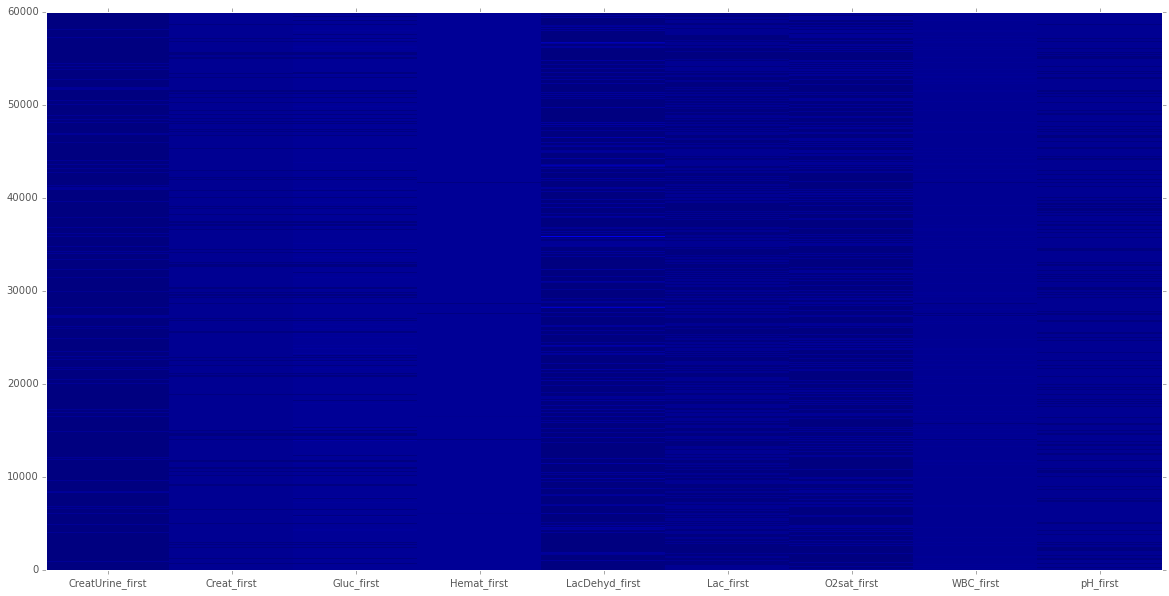

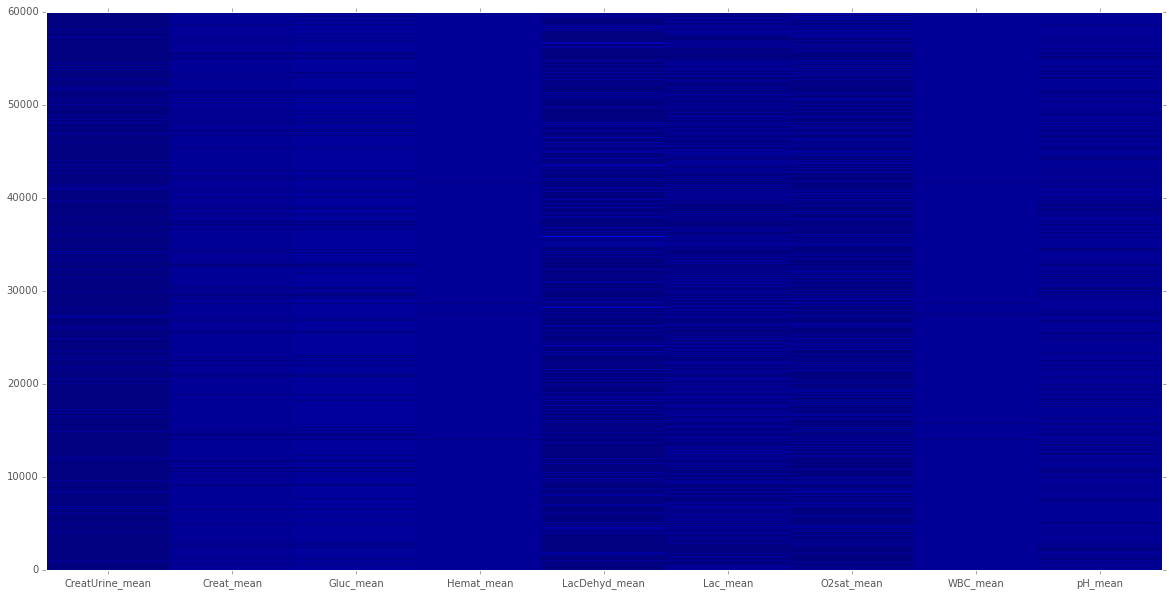

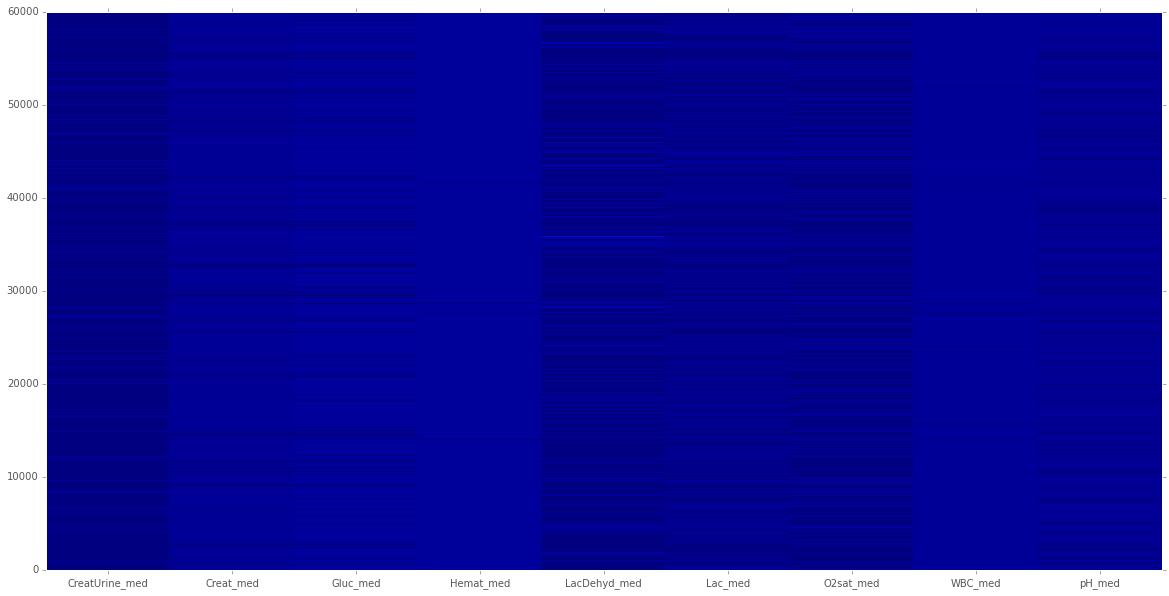

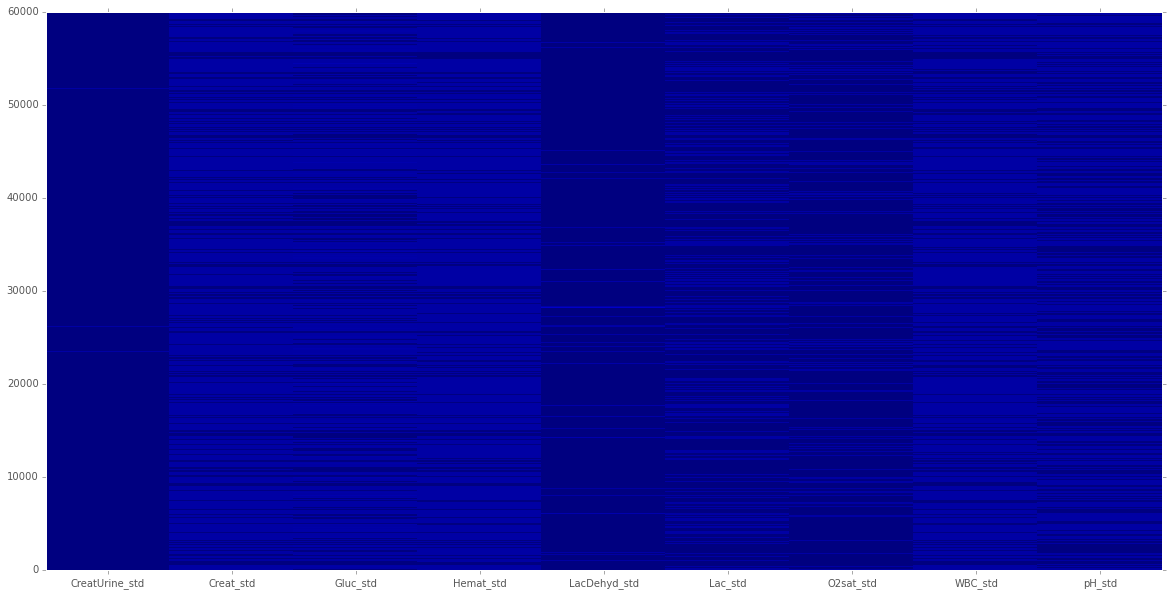

In [ ]:
# DISPLAY COLORMAP OF DATA 

for calc in calc_list:
    plt.figure(figsize= (20,10))
    cols = [x for x in data3.columns if calc in x] 
    cols.sort()
    header = data3[cols]
    for col in header.columns:
        min_val = header[col].min()
        header[col].replace(np.nan, min_val-1000, inplace = True)
    plt.pcolor(header)
    plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
    plt.show()

'''
plt.figure(figsize= (20,10))
header = data3[data3.columns[11:18]].replace(np.nan, 10000, inplace = False)
plt.pcolor(header)
plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
plt.show()
'''


In [ ]:
# CREATING NEW DATAFRAME FOR NORMALIZING DATA AND REMOVING OUTLIERS

cont_cols = list(data3.columns[data3.dtypes == 'float64'])
cont_cols.insert(0, 'hospital_expire_flag')
cont_cols.insert(0, 'gender')
#data4 = data3[list(data3.columns[data3.dtypes == 'float64'])]
data4 = data3[cont_cols]
display(data4.shape)
display(data4.head())

## Creating a Dataframe of skewness measurements for the raw data and for different transforms to calculate what transform does the best job of normalizing the data

In [ ]:
# TRANFORMS LIKE BOXCOX REQUIRE POSITIVE DATA SO WE'LL SHIFT DATA POSITIVE
below_zeros = list(data4.columns[data4.min() < 0])
for col in below_zeros:
    col_min = data4[col].min()
    data4.loc[:,col] = data4[col].apply(lambda x: x-col_min)






# create dict from which we'll build skew measures dataframe
skew_dict = {data4.columns[2]:
              {
             'raw_skew': scats.skew(data4[data4.columns[2]].dropna()), 
             'sqrt_skew': scats.skew(np.sqrt(data4[data4.columns[2]].dropna())), 
             'log_skew': scats.skew(np.log(data4[data4.columns[2]].dropna().add(1))),  
             'boxcox_skew': scats.skew(scats.boxcox(data4[data4.columns[2]].dropna().add(1))[0])
             }
             }

print skew_dict
skew_df = pd.DataFrame.from_dict(skew_dict, orient = 'index')  
# re-order columns
skew_df = skew_df[['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew']]
skew_df

In [ ]:
for col in data4.columns[3:]:
    raw_skew = scats.skew(data4[col].dropna())
    
    sqrt_skew = scats.skew(np.sqrt(data4[col].dropna()))
    log_skew = scats.skew(np.log(data4[col].dropna().add(1)))
        #print "{} logskew = {}".format(col, new_skew_val2)
    boxcox_skew = scats.skew(scats.boxcox(data4[col].dropna().add(1))[0])
    new_row = pd.Series([raw_skew, sqrt_skew, log_skew, boxcox_skew],
                        #index=['measurement', 'raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                        index=['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                       name = col)

    skew_df = skew_df.append(new_row)#, ignore_index = True)

skew_df.columns.name = 'Skewness Values'
skew_df.index.name = 'Lab Measures'
skew_df

## The figure below shows the skewness values for each lab measurement for normalized data that has been transformed by taking the log, the square root and using the box-cox function. It can be seen that the box-cox function performed better than other transforms in reducing skewness. 


In [ ]:
skew_df.head()

In [ ]:
ax = skew_df.head(10).plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
ax.set_ylabel("Skewness")

In [ ]:
data4.dropna().describe()

In [ ]:
#sqrt_norm_data = np.sqrt(data2_norm[data2_norm.columns[1:]])
#log_norm_data = np.log(data2_norm[data2_norm.columns[1:]].add(1))
boxcox_data = data4.copy()
for feature_name in data4.columns[2:]:
    boxcox_data[feature_name] = scats.boxcox(data4[feature_name].add(1))[0]

display(boxcox_data.dropna().describe())


In [ ]:
boxcox_data.isnull().sum()

In [ ]:



 
for col in boxcox_data.columns[2:10]:
    
    
    
    dummy = boxcox_data[['hospital_expire_flag', 'gender', col]].dropna()
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        
        #print gend
        dead = dummy[(dummy.hospital_expire_flag == 1)&
                              (dummy.gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[(dummy.hospital_expire_flag == 0)&
                              (dummy.gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col].dropna().max()#quantile(0.999)
        live_min = live[col].dropna().min()#quantile(0.001)
        dead_max = dead[col].dropna().max()#quantile(0.999)
        dead_min = dead[col].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        if ((live[col].dropna().shape[0] > 10) & (dead[col].dropna().shape[0] > 10)):
            plt.subplots(figsize=(10,4))
            live[col].dropna().plot.kde(alpha=1.0,label='Survival')
            dead[col].dropna().plot.kde(alpha=1.0,label='Non-Survivors')
            # add title, labels etc.
            plt.title('{} measurement on ICU admission'.format(col) + 
                       'vs ICU mortality by gender = {}\n'.format(gend))
            plt.xlabel(col)
            plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
            #print "{}    {}".format(maxlim, minlim)
            #plt.xlim(minlim, maxlim)
        else: 
            print "empty data set for {}".format(col)

In [ ]:
print col
live[col].dropna().head(30)

In [ ]:
live.head()

In [ ]:
plt.close('all')

## Code to identify outliers in normalized data

In [ ]:
names_dict = {}
suffix = '_outliers'


for feature in boxcox_data.keys():
    if feature != 'mort_icu':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(boxcox_data[feature], 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(boxcox_data[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = boxcox_data[~((boxcox_data[feature] >= Q1 - step) & (boxcox_data[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove

## Code to remove datapoints from normalized data with 3 or more variables that are outliers

In [ ]:
all_outliers = []
for feature in names_dict.keys():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts >= 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)

In [ ]:

# I believe this can be done more efficiently with sklearn.preprocessing.scale
boxcox_data_scaled = boxcox_data2.copy()
for feature_name in boxcox_data2.columns[1:]:
#    max_value = data2[feature_name].max()
#    min_value = data2[feature_name].min()
#    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)
    boxcox_data_scaled[feature_name] = preprocessing.scale(boxcox_data_scaled[feature_name], with_mean = True, 
                                                  with_std = True)
    
display(boxcox_data_scaled.head())
display(boxcox_data.head())


In [ ]:
# CALCULATING THE QUARTILES ON THE DISTRIBUTIONS AND BINNING DATA INTO 4 BUCKETS
# DATA IS NOT NORMAL SO WE MAY WANT TO NORMALIZE PRIOR TO THIS STEP


for col in data4.columns:
    Q1 = np.percentile(data4[col], 25)
    Q2 = np.percentile(data4[col], 50)
    Q3 = np.percentile(data4[col], 75)
    Q3 = np.percentile(data4[col], 100)
     
    
    

# POINT OF WRITING DATA TO FILE FOR PASSING ON TO ICU_MORTALITY_FIRST.ipynb

In [ ]:
ptnt_demog = pd.DataFrame.from_csv('PTNT_DEMOG_ANGUS_rev.csv')
ptnt_demog.shape

## Determine which variables are continuous / float64 and perform feature selection. 
May not be the right point to do this, need additional preprocessing. 


In [ ]:
data4 = data3.dropna()
X_continuous = data4[list(data4.columns[data4.dtypes == 'float64'])]
y = data4['hospital_expire_flag']
display(X_continuous.shape)
display(y.shape)

below_zeros = list(X_continuous.columns[X_continuous.min() < 0])
below_zeros

for col in below_zeros:
    col_min = X_continuous[col].min()
    X_continuous.loc[:,col] = X_continuous[col].apply(lambda x: x-col_min)

    
    
display(X_continuous.head())
display(y.head())

selector = SelectKBest(k=10)
selector.fit(X_continuous, y)
print "p_vals            scores           feature"
for i in range(len(selector.pvalues_)):
    print "{}    {}   {}".format(selector.pvalues_[i], selector.scores_[i], X_continuous.columns[i])
#X_new, p_vals = SelectKBest(chi2, k=10).fit_transform(X_continuous, y)
#X_new.shape
largest = pd.Series(selector.scores_).nlargest(30)
X_continuous.columns[largest.index]

p_vals = pd.Series(selector.pvalues_, name = 'p_values', index = X_continuous.columns)
scores = pd.Series(selector.scores_, name = 'scores', index = X_continuous.columns)
cont_features_df = pd.concat([p_vals, scores], axis = 1)
cont_features_df.sort_values(by ='scores', ascending = False).head(30)

In [ ]:
display(data3.columns)
display(ptnt_demog.columns)

In [ ]:
ptnt_demog2 = ptnt_demog[['gender', 'marital_status', 'ethnicity', 'insurance', 'first_careunit', 
                          'age', 'hospital_expire_flag']]
ptnt_demog2.head()

## Merging the patient demographic and summary chart data

In [ ]:
data4 = data3.copy()
data4 = data4.merge(ptnt_demog2, left_index = True, right_index = True, how='left', sort = True)
data4.head()

In [ ]:
data4.isnull().sum()

In [ ]:
#df[np.isfinite(df['EPS'])]
#data4[np.isfinite(data4['CO_max'])].shape
#data5 = data4.drop(['CO_max', 'HR2_mean'], axis = 1)
# DROP COLUMNS WHERE THERE ARE (ARBITRARILY) < 7600 VALUES
data5 = data4[data4.columns[data4.isnull().sum() < 7600]]
data5.head()



In [ ]:
data5.dtypes

In [ ]:
float_vars = data5.dtypes[data5.dtypes == 'float'].index
cat_vars = data5.dtypes[data5.dtypes == 'object'].index
int_vars = data5.dtypes[data5.dtypes == 'int64'].index
cat_vars = cat_vars.drop(['value'])

In [ ]:
#int_vars = int_vars.drop(['subject_id', 'hospital_expire_flag', 'angus'])
#int_vars

In [ ]:
# HR2
display(data5.dropna().shape)
display(data5[data5.hospital_expire_flag == 1].dropna().shape)
display(data5[data5.hospital_expire_flag == 0].dropna().shape)

In [ ]:
for thing in cat_vars[1:2]:
    cats = list(data5[thing].unique())
    print cats

In [ ]:
for thing in cat_vars[:2]:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats



In [ ]:
for thing in cat_vars:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats

    for cat in cats:
        dead = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 1)].dropna().count()
        live = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 0)].dropna().count()
        total = float(live) + dead
        datadict[cat] = (live/total, dead/total)

    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + thing)
    plt.show()


In [ ]:
len(int_vars)
int_vars[1:len(int_vars)-1]

In [ ]:
for thing in int_vars[1:len(int_vars)-1]:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats

    for cat in cats:
        dead = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 1)].dropna().count()
        live = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 0)].dropna().count()
        #total = float(live) + dead
        #datadict[cat] = (live/total, dead/total)
        datadict[cat] = (live, dead)
    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + thing)
    plt.show()


In [ ]:
float_vars

In [ ]:
for thing in float_vars:
    # plot
    plt.subplots(figsize=(13,6))
    data5[thing][data5.hospital_expire_flag==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival')
    data5[thing][data5.hospital_expire_flag==0].dropna().plot.kde(
        alpha=1.0,label='Survival')
    
  

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(thing.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(thing)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data5[thing].dropna().quantile(0.99))
    
  

In [ ]:
dead_men = data5.gender[(data5['gender']=='M') & (data5.hospital_expire_flag ==1)].dropna().count()
dead_women = data5.gender[(data5['gender']=='F') & (data5.hospital_expire_flag ==1)].dropna().count()
live_men = data5.gender[(data5['gender']=='M') & (data5.hospital_expire_flag ==0)].dropna().count()
live_women = data5.gender[(data5['gender']=='F') & (data5.hospital_expire_flag ==0)].dropna().count()
survival = pd.DataFrame([[live_men, live_women], 
                        [dead_men, dead_women]], 
                       columns = ['Men', 'Women'],
                       index = ['Survivors', 'Non_Survivors'])
survival

In [ ]:
survival.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                             alpha = 0.5)

In [ ]:
np.arange(2)

In [ ]:
ind = np.arange(1,3)    # the x locations for the groups
width = 0.25       # the width of the bars: can also be len(x) sequence

plt.figure(figsize= (20,10))
p1 = plt.bar(ind - width/2, survival.iloc[0], width, color = 'green', edgecolor = 'black',
            linewidth = 3)
p2 = plt.bar(ind - width/2, survival.iloc[1], width, color = 'red', edgecolor = 'black', 
             linewidth = 3, bottom=survival.iloc[0])

plt.ylabel('Number of Patients')
plt.title('Survivors vs. Non-Survivors')
plt.xticks(ind, ('Men', 'Women'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Survivors', 'Non_Survivors'))

plt.show()

In [ ]:
#ax = skew_df.plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
#ax.set_ylabel("Skewness")
#data5.groupby(['hospital_expire_flag'])[['gender']].count().plot(kind='bar', stacked = True )
data5[cat_vars].plot.hist()

In [ ]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}
'''
# a list is created containing units of measure for the lab measurements
lab_units = ['g/dL',
        'mEq/L',
        'mEq/L',
        'mg/dL',
        '',
        'mEq/L',
        'mg/dL',
        'mg/dL',
        '%', 
        'g/dL',
        '',
        'mmol/L',
        'mmol/L',
        'mg/dL',
        'K/uL',
        'mEq/L',
        '',
        'sec',
        'mmol/L',
        '']

# currently using lab_measures and lab_units to create the dict. 
# could be done more succinctly using the dictionary described above
labs_dict = dict(zip(lab_measures, lab_units))
print labs_dict


In [ ]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = data[l][data.mort_icu==1].dropna().count()
    n_surv = data[l][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l][data.mort_icu==1].dropna().median()
    med_surv = data[l][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l][data.mort_icu==1].dropna().var()
    var_surv = data[l][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l][data.mort_icu==1].dropna().skew()
    skew_surv = data[l][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Generating box-plots for each variable for both survival and non-survival groups. 

In [ ]:
# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    #fig, ax1 = plt.subplots(figsize=(13, 6))
    #fig.canvas.set_window_title('A Boxplot Example')
    #plt.subplots(figsize=(13,6))
    #box_data = data[['mort_icu', l.lower()+'_1st']].dropna()
    data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
   #data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
    #    label='Non-survival (n={})'.format(n_nonsurv))
    plt.suptitle("")
    '''
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.box(
        label='Survival (n={})'.format(n_surv))
    '''
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    
   # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data[l.lower()+'_1st'].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    
    

## From the density plots above, a list of variables was generated for which the distribution was very similar between survival and non-survival groups. (Maybe include similarity threshold??)

In [ ]:
# Generate list of variables which, from density plots above, are similar between surivial and non-survival groups
cols_list = list(data.columns)
remove_list = ['chloride_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'platelet_1st']
for element in remove_list:
    cols_list.remove(element)
    
display(cols_list)

In [ ]:
# data4 includes all variables except those identified as similar between survival and non-survival groups. 
data2 = data[cols_list]
data2.head()

## Removing data points that include any NaN values

In [ ]:
# remove samples which have any values that are nan
data2 = data2.dropna()
data2.set_index(np.arange(data2.shape[0]), inplace = True)
data2.head()

## The survival rate calculated below indicates that 82% of patients survived. 

In [ ]:
dead = data2['mort_icu'][data2.mort_icu==1].count()
survivors = data2['mort_icu'][data2.mort_icu==0].count()
survival_rate = float(survivors)/(dead+survivors)
print "Number of  patients deceased = {}".format(dead)
print "Number of patients           = {}".format(dead + survivors)
print "Survival Rate                = {}".format(survival_rate * 100)

## Support Vector Machine Classification on un-processed data with variables selected based on visual inspection
The variables enumerated in 'remove_list' were observed for both survivors and non-survivors and appeared to be very similar in distribution. Because they appeared to be very similar for both groups, they were excluded as features for classification. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.30, random_state = 42)

clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, data2[data2.columns[1:]], data2['mort_icu'], cv=5)
display(scores)  


In [ ]:
clf_SVC.score(X_test, y_test)
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

## The Confusion Matrix indicates that the classifier simply predicts survival for each patient which, because 82% of the patients survived, results in 82% Accuracy. 

## Gaussian Naive Bayes Classification on un-processed data with variables selected based on visual inspection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.40, random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



## The Confusion Matrix indicates that the classifier predicts survival rates with ~78% accuracy with a mixture of predictions rather than predicting all survival as was the case for the SVM classifier. Unfortunately, the accuracy is not better than predicting all survivors. 

## Multi-Layer Perceptron Classification on un-processed data with variables selected based on visual inspection

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.20, random_state = 42)

clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(7, 4), random_state=1)

clf_MLP.fit(X_train, y_train)                         

display(clf_MLP.score(X_test, y_test))
y_predsMLP = clf_MLP.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)




## Creating a Dataframe of skewness measurements for the raw data and for different transforms to calculate what transform does the best job of normalizing the data

In [ ]:
# create dict from which we'll build skew measures dataframe
skew_dict2 = {data2.columns[1]:
              {
             'raw_skew': scats.skew(data2[data2.columns[1]]), 
             'sqrt_skew': scats.skew(np.sqrt(data2[data2.columns[1]])), 
             'log_skew': scats.skew(np.log(data2[data2.columns[1]].add(1))),  
             'boxcox_skew': scats.skew(scats.boxcox(data2[data2.columns[1]].add(1))[0])
             }
             }

print skew_dict2
skew_df = pd.DataFrame.from_dict(skew_dict2, orient = 'index')  
skew_df

In [ ]:
# re-order columns
skew_df = skew_df[['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew']]


In [ ]:
skew_df

In [ ]:
              
for col in data2.columns[2:]:
    raw_skew = scats.skew(data2[col])
    
    sqrt_skew = scats.skew(np.sqrt(data2[col]))
    log_skew = scats.skew(np.log(data2[col].add(1)))
        #print "{} logskew = {}".format(col, new_skew_val2)
    boxcox_skew = scats.skew(scats.boxcox(data2[col].add(1))[0])
    new_row = pd.Series([raw_skew, sqrt_skew, log_skew, boxcox_skew],
                        #index=['measurement', 'raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                        index=['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                       name = col)

    skew_df = skew_df.append(new_row)#, ignore_index = True)

skew_df

In [ ]:
skew_df.columns.name = 'Skewness Values'
skew_df.index.name = 'Lab Measures'

## The figure below shows the skewness values for each lab measurement for normalized data that has been transformed by taking the log, the square root and using the box-cox function. It can be seen that the box-cox function performed better than other transforms in reducing skewness. 


In [ ]:
ax = skew_df.plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
ax.set_ylabel("Skewness")

In [ ]:
#sqrt_norm_data = np.sqrt(data2_norm[data2_norm.columns[1:]])
#log_norm_data = np.log(data2_norm[data2_norm.columns[1:]].add(1))
boxcox_data = data2.copy()
for feature_name in data2.columns[1:]:
    boxcox_data[feature_name] = scats.boxcox(data2[feature_name].add(1))[0]

boxcox_data.head()

## Code to identify outliers in normalized data

In [ ]:
names_dict = {}
suffix = '_outliers'


for feature in boxcox_data.keys():
    if feature != 'mort_icu':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(boxcox_data[feature], 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(boxcox_data[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = boxcox_data[~((boxcox_data[feature] >= Q1 - step) & (boxcox_data[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove

## Code to remove datapoints from normalized data with 3 or more variables that are outliers

In [ ]:
all_outliers = []
for feature in names_dict.keys():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts >= 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)

In [ ]:

# I believe this can be done more efficiently with sklearn.preprocessing.scale
boxcox_data_scaled = boxcox_data2.copy()
for feature_name in boxcox_data2.columns[1:]:
#    max_value = data2[feature_name].max()
#    min_value = data2[feature_name].min()
#    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)
    boxcox_data_scaled[feature_name] = preprocessing.scale(boxcox_data_scaled[feature_name], with_mean = True, 
                                                  with_std = True)
    
display(boxcox_data_scaled.head())
display(boxcox_data.head())


In [ ]:
#remove_list

In [ ]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs_dict2 = labs_dict

# could be done more succinctly using the dictionary described above

for item in remove_list:
    del labs_dict2[item]

print labs_dict2
print boxcox_data_scaled.columns

import collections
labs_dict3 = collections.OrderedDict(sorted(labs_dict2.items()))
labs_dict3
'''

## Plotting frequency distribution for each lab measurement for both survival and non-survival groups. 

In [ ]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().count()
    n_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().median()
    med_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().median()
    var_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().var()
    var_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().var()
    skew_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().skew()
    skew_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna(),
                              boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    #plt.xlim(0, boxcox_data_scaled[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Performing PCA on box-cox transformed, scaled data with outliers removed

In [ ]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 4).fit(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], pca)


In [ ]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']) #,
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

## Scatterplot of Box-Cox transformed data with outliers removed. 

In [ ]:
pd.scatter_matrix(boxcox_data_scaled[1:], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(reduced_data, 
                                                    boxcox_data_scaled['mort_icu'], test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


## Box-Cox transformed data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], 
                                                    boxcox_data_scaled['mort_icu'], test_size = 0.40, random_state = 42)


clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)



In [ ]:
data[data.columns[5:]].head()

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [ ]:
boxcox_dead = boxcox_data_scaled[boxcox_data_scaled.mort_icu == 1]
boxcox_survivors = boxcox_data_scaled[boxcox_data_scaled.mort_icu == 0]
display(boxcox_dead.shape[0])
display(boxcox_survivors.shape[0])
boxcox_survivors_reduced = boxcox_survivors.sample(boxcox_dead.shape[0])
frames = [boxcox_survivors_reduced, boxcox_dead]
boxcox_even = pd.concat(frames)
boxcox_even.shape

In [ ]:
num_samps = boxcox_even.shape[0]
display(num_samps)

boxcox_even2 = boxcox_even.sample(n=num_samps)
#boxcox_even2.shape()
boxcox_even2.shape

In [ ]:
boxcox_even2.head(10)

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.40, 
                                                    random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


## Support Vector Machine Classification on un-processed data with variables selected based on visual inspection
The variables enumerated in 'remove_list' were observed for both survivors and non-survivors and appeared to be very similar in distribution. Because they appeared to be very similar for both groups, they were excluded as features for classification. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.30, 
                                                    random_state = 42)



clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, boxcox_data_scaled[boxcox_data_scaled.columns[1:]], 
                         boxcox_data_scaled['mort_icu'], cv=5)
display(scores)  
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

In [ ]:
display(clf_SVC.score(X_test, y_test))
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.30, 
                                                    random_state = 42)

clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)



In [ ]:
print "monkey"

In [ ]:
diagnoses_codes = pd.DataFrame.from_csv('IDC9_DEADLY_DIAGNOSES.csv')
diagnoses_codes.head()

In [ ]:
diagnoses_list = diagnoses_codes.icd9_code.unique()
diagnoses_list2 = diagnoses_codes.diagnosis.unique()
display(len(diagnoses_list))
display(len(diagnoses_list2))

In [ ]:
unique_codes = diagnoses_codes.drop_duplicates(['icd9_code', 'short_title'])
unique_codes.shape


In [ ]:
unique_codes.head()

In [ ]:
len(diagnoses_list)

In [ ]:
diag_counts = diagnoses_codes.icd9_code.value_counts()

In [ ]:
diag_counts[0:10]

In [ ]:
diagnoses_list[0:10]

In [ ]:
boxcox_data_scaled.columns

In [ ]:
boxcox_data_scaled_subset = boxcox_data_scaled[['mort_icu', 'albumin_1st', 'bicarbonate_1st', 'inr_1st', 'phosphate_1st',
                                                'ptt_1st']]
boxcox_data_scaled_subset.head()

In [ ]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 3).fit(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], pca)


In [ ]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']) #,
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

## Scatterplot of Box-Cox transformed data with outliers removed. 

## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [ ]:
feat_list = list(boxcox_data_scaled_subset.columns[1:])
feat_list

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(boxcox_data_scaled_subset[feat_list], 
                                                    boxcox_data_scaled_subset['mort_icu'], 
                                                    test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)
